<a href="https://colab.research.google.com/github/benalperbozkurt/DeepFake_FaceSwap/blob/main/06_04_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - loss: 0.0707 - val_loss: 0.0785
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - loss: 0.0422 - val_loss: 0.0650
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - loss: 0.0363 - val_loss: 0.0437
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - loss: 0.0344 - val_loss: 0.0442
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 301s 6s/step - loss: 0.0307 - val_loss: 0.0425
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 308s 6s/step - loss: 0.0284 - val_loss: 0.0469
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 308s 6s/step - loss: 0.0282 - val_loss: 0.0349
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - loss: 0.0245 - val_loss: 0.0275
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - loss: 0.0231 - val_loss: 0.0289
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - loss: 0.0220 - val_loss: 0.0269
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - loss: 0.0205 - val_loss: 0.0251
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━

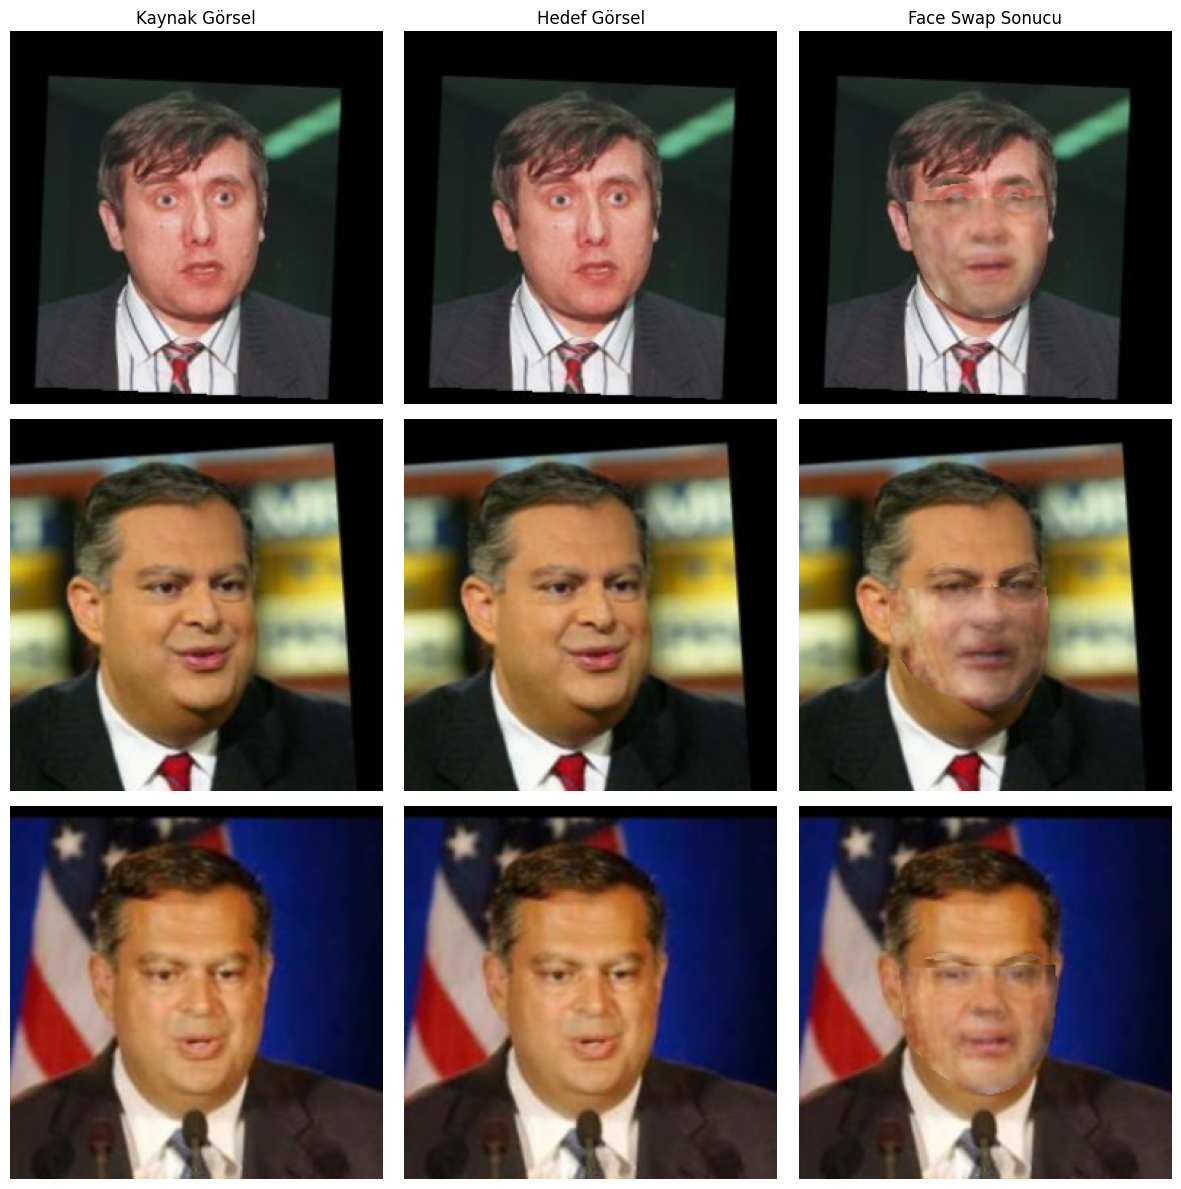

In [ ]:
# Gerekli kütüphaneler
import os
import cv2
import numpy as np
import dlib
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

# Google Drive bağlantısı
drive.mount('/content/drive')

# Veri yolları
data_dir = "/content/drive/MyDrive/DataSets/lfw-deepfunneled/lfw-deepfunneled"
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

# Veri setini yükleme fonksiyonu (8 sınıf maskeli)
def load_lfw_images(data_dir, image_size=(256, 256), max_images=1000):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    images, masks = [], []
    count = 0

    for person_name in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person_name)
        if not os.path.isdir(person_path):
            continue

        for img_name in os.listdir(person_path):
            if img_name.endswith(".jpg"):
                img_path = os.path.join(person_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, image_size)

                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                faces = detector(gray)

                if len(faces) > 0:
                    landmarks = predictor(gray, faces[0])
                    points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)])
                    mask = np.zeros(img.shape[:2], dtype=np.uint8)

                    # 8 farklı bölgeye ayrı etiket ver
                    cv2.fillConvexPoly(mask, points[0:17], 1)     # Çene
                    cv2.fillConvexPoly(mask, points[17:22], 2)    # Sağ kaş
                    cv2.fillConvexPoly(mask, points[22:27], 3)    # Sol kaş
                    cv2.fillConvexPoly(mask, points[27:36], 4)    # Burun
                    cv2.fillConvexPoly(mask, points[36:42], 5)    # Sağ göz
                    cv2.fillConvexPoly(mask, points[42:48], 6)    # Sol göz
                    cv2.fillConvexPoly(mask, points[48:60], 7)    # Dış ağız
                    cv2.fillConvexPoly(mask, points[60:68], 8)    # İç ağız

                    images.append(img / 255.0)  # Normalize edilmiş RGB
                    masks.append(mask.astype(np.uint8))  # Sınıf etiketli maske

                    count += 1
                    if count >= max_images:
                        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

# Veriyi yükle
lfw_images, lfw_masks = load_lfw_images(data_dir, max_images=1000)

# Eğitim/test böl
X_train, X_test, M_train, M_test = train_test_split(lfw_images, lfw_masks, test_size=0.2, random_state=42)

#veriyi sıkıştır, aç ve hata ölç
def build_gan(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256 * 256 * 3, activation='sigmoid')(x)
    outputs = Reshape((256, 256, 3))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Modeli oluştur ve eğit
face_swap_model = build_gan()
face_swap_model.fit(X_train, X_train, epochs=20, batch_size=16, validation_data=(X_test, X_test))

# Maske üzerinden yüz swap işlemi
def apply_face_swap(model, source_faces, masks):
    swapped_faces = model.predict(source_faces)

    masks_expanded = np.expand_dims(masks, axis=-1)  # (B, H, W, 1)
    masks_binary = np.where(masks_expanded > 0, 1.0, 0.0)  # Sıfır olan yer dışı bölge
    masks_binary = masks_binary.astype(np.float32)

    return swapped_faces * masks_binary + source_faces * (1.0 - masks_binary)

# Swap işlemi uygula
swapped_images = apply_face_swap(face_swap_model, X_test, M_test)

# Sonuçları görselleştirme
def visualize_results(sources, targets, swapped, n=3):
    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        ax = plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(sources[i])
        plt.axis("off")
        if i == 0:
            ax.set_title("Kaynak Görsel")

        ax = plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(targets[i])
        plt.axis("off")
        if i == 0:
            ax.set_title("Hedef Görsel")

        ax = plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(swapped[i])
        plt.axis("off")
        if i == 0:
            ax.set_title("Face Swap Sonucu")
    plt.tight_layout()
    plt.show()

# Görselleştir
visualize_results(X_test, X_test, swapped_images, n=3)


In [ ]:
def process_image(img_path, image_size=(256, 256)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    faces = detector(gray)

    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    if len(faces) > 0:
        landmarks = predictor(gray, faces[0])
        points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)])

        cv2.fillConvexPoly(mask, points[0:17], 1)     # Çene
        cv2.fillConvexPoly(mask, points[17:22], 2)    # Sağ kaş
        cv2.fillConvexPoly(mask, points[22:27], 3)    # Sol kaş
        cv2.fillConvexPoly(mask, points[27:36], 4)    # Burun
        cv2.fillConvexPoly(mask, points[36:42], 5)    # Sağ göz
        cv2.fillConvexPoly(mask, points[42:48], 6)    # Sol göz
        cv2.fillConvexPoly(mask, points[48:60], 7)    # Dış ağız
        cv2.fillConvexPoly(mask, points[60:68], 8)    # İç ağız

    return img / 255.0, mask.astype(np.uint8)

def apply_single_face_swap(model, source_img, target_img, target_mask):
    source_img_input = np.expand_dims(source_img, axis=0)
    predicted = model.predict(source_img_input)[0]

    mask_exp = np.expand_dims(target_mask, axis=-1)
    mask_binary = np.where(mask_exp > 0, 1.0, 0.0).astype(np.float32)

    result = predicted * mask_binary + target_img * (1 - mask_binary)
    return result

def show_single_swap(source, target, result):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(source)
    plt.title("Kaynak Görsel")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(target)
    plt.title("Hedef Görsel")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Face Swap Sonucu")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
# kaynak ve hedef yüz teker teker sınıflandırılıp face swap işlemi uygulandı.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


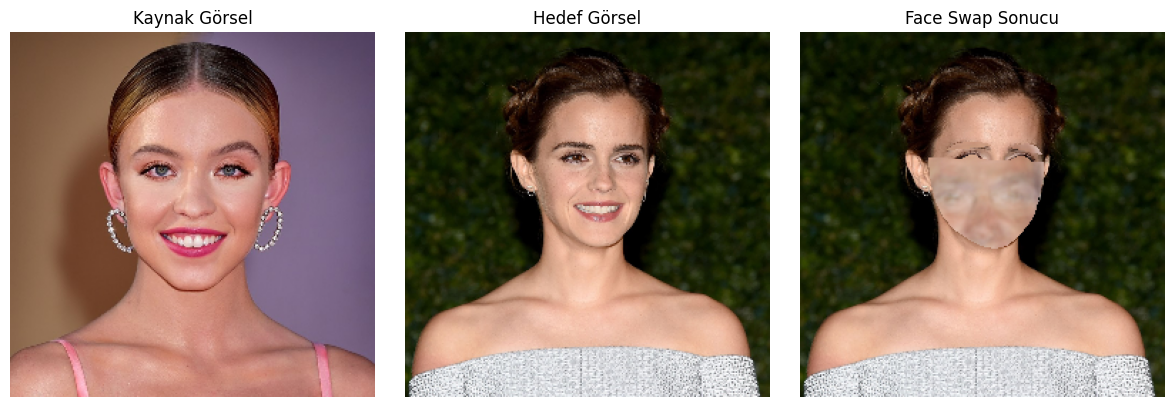

In [ ]:
source_path = "/content/drive/MyDrive/source1.jpg"
target_path = "/content/drive/MyDrive/target1.jpg"

source_img, _ = process_image(source_path)
target_img, target_mask = process_image(target_path)

swapped = apply_single_face_swap(face_swap_model, source_img, target_img, target_mask)
show_single_swap(source_img, target_img, swapped)


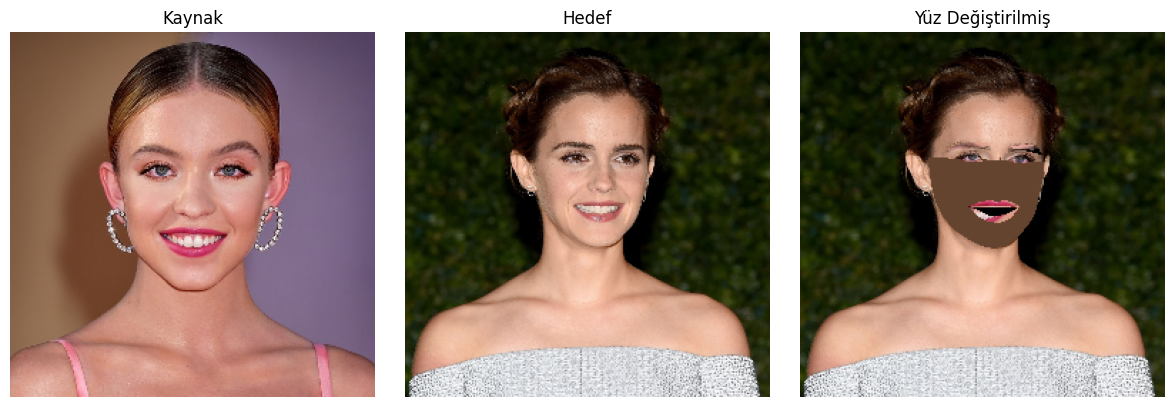

In [ ]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# 8 sınıfa göre indeks grupları
REGIONS = {
    "chin": list(range(0, 17)),
    "right_eyebrow": list(range(17, 22)),
    "left_eyebrow": list(range(22, 27)),
    "nose": list(range(27, 36)),
    "right_eye": list(range(36, 42)),
    "left_eye": list(range(42, 48)),
    "mouth_out": list(range(48, 60)),
    "mouth_in": list(range(60, 68)),
}

predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)
detector = dlib.get_frontal_face_detector()

def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    shape = predictor(gray, faces[0])
    return np.array([[pt.x, pt.y] for pt in shape.parts()], dtype=np.int32)

def warp_region(src_img, dst_img, src_pts, dst_pts, region_idx):
    src_region = np.float32([src_pts[i] for i in region_idx])
    dst_region = np.float32([dst_pts[i] for i in region_idx])

    if len(src_region) < 3 or len(dst_region) < 3:
        return dst_img  # Affine için en az 3 nokta gerekli

    M = cv2.getAffineTransform(src_region[:3], dst_region[:3])
    warped = cv2.warpAffine(src_img, M, (dst_img.shape[1], dst_img.shape[0]))

    # Maske oluştur
    mask = np.zeros(dst_img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, dst_region.astype(np.int32), 255)
    mask = mask[:, :, np.newaxis] / 255.0

    # Blend et
    return (warped * mask + dst_img * (1 - mask)).astype(np.uint8)

def face_swap_with_affine(src_img, dst_img):
    src_pts = get_landmarks(src_img)
    dst_pts = get_landmarks(dst_img)

    if src_pts is None or dst_pts is None:
        print("Landmark bulunamadı.")
        return dst_img

    result = dst_img.copy()

    for region in REGIONS.values():
        result = warp_region(src_img, result, src_pts, dst_pts, region)

    return result

# Uygulama ve görselleştirme
src = cv2.imread("/content/drive/MyDrive/source1.jpg")
dst = cv2.imread("/content/drive/MyDrive/target1.jpg")

src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

src = cv2.resize(src, (256, 256))
dst = cv2.resize(dst, (256, 256))

swapped = face_swap_with_affine(src, dst)

# Görselleştirme
plt.figure(figsize=(12, 4))
titles = ["Kaynak", "Hedef", "Yüz Değiştirilmiş"]
images = [src, dst, swapped]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()
# landmarklar üzerine hatalı bir deneme

In [ ]:
# Dlib ile landmark ve bölge maskesi oluşturma
def get_landmarks_and_regions(img, predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        raise ValueError("Yüz bulunamadı")

    landmarks = predictor(gray, faces[0])
    points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)])
    return points

# Maske sınıflarını bölgelere ayır
def get_region_indices():
    return {
        1: list(range(0, 17)),     # Çene
        2: list(range(17, 22)),    # Sağ kaş
        3: list(range(22, 27)),    # Sol kaş
        4: list(range(27, 36)),    # Burun
        5: list(range(36, 42)),    # Sağ göz
        6: list(range(42, 48)),    # Sol göz
        7: list(range(48, 60)),    # Dış ağız
        8: list(range(60, 68)),    # İç ağız
    }

# Belirli landmark'lara göre bölge maskesi al
def extract_region(img, landmarks, indices):
    region_points = np.array([landmarks[i] for i in indices])
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, region_points, 255)
    bbox = cv2.boundingRect(region_points)
    cropped = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    region_mask = mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    return cropped, region_mask, bbox

# Region'ı hedefe seamless clone ile yapıştır
def paste_region(target_img, source_crop, source_mask, dest_bbox):
    center = (dest_bbox[0] + dest_bbox[2] // 2, dest_bbox[1] + dest_bbox[3] // 2)
    return cv2.seamlessClone(source_crop, target_img, source_mask, center, cv2.NORMAL_CLONE)

# --- Ana işlem: kaynak -> hedef yüz değiştirme
def face_swap_from_drive(source_path, target_path, predictor_path):
    src = cv2.imread(source_path)
    tgt = cv2.imread(target_path)
    src = cv2.cvtColor(cv2.resize(src, (256, 256)), cv2.COLOR_BGR2RGB)
    tgt = cv2.cvtColor(cv2.resize(tgt, (256, 256)), cv2.COLOR_BGR2RGB)

    src_points = get_landmarks_and_regions(src, predictor_path)
    tgt_points = get_landmarks_and_regions(tgt, predictor_path)
    region_map = get_region_indices()

    result = tgt.copy()

    for label, indices in region_map.items():
        src_crop, src_mask, _ = extract_region(src, src_points, indices)
        _, _, tgt_bbox = extract_region(tgt, tgt_points, indices)

        # Resize source crop to match target bbox
        src_crop_resized = cv2.resize(src_crop, (tgt_bbox[2], tgt_bbox[3]))
        src_mask_resized = cv2.resize(src_mask, (tgt_bbox[2], tgt_bbox[3]))

        # Yapıştır (seamless clone)
        result = paste_region(result, src_crop_resized, src_mask_resized, tgt_bbox)

    return src, tgt, result
# maskeleme bölgeleri güncellendi

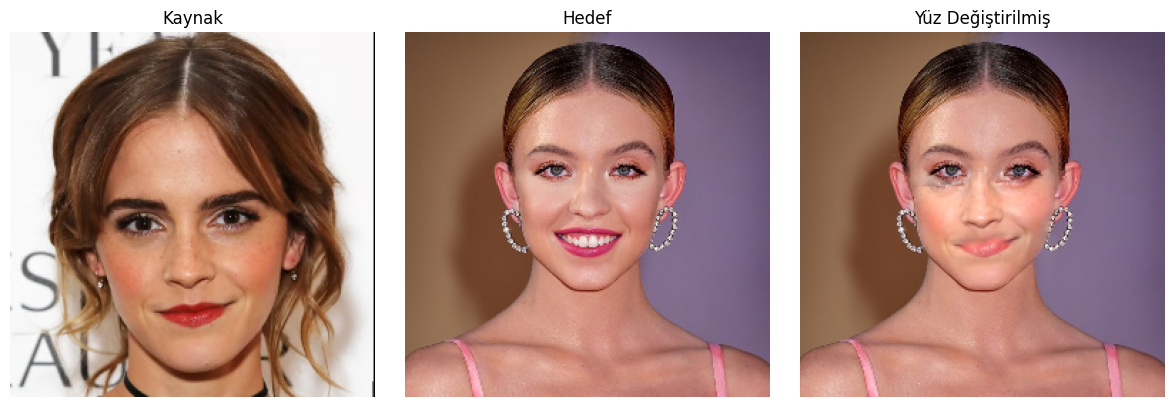

In [ ]:
# Drive'dan path
source_img_path = "/content/drive/MyDrive/emma_watson.jpg"
target_img_path = "/content/drive/MyDrive/sydney_sweeny.jpg"

# Yüz değiştir
src_img, tgt_img, swapped_img = face_swap_from_drive(source_img_path, target_img_path, predictor_path)

# Göster
plt.figure(figsize=(12, 4))
titles = ["Kaynak", "Hedef", "Yüz Değiştirilmiş"]
for i, img in enumerate([src_img, tgt_img, swapped_img]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


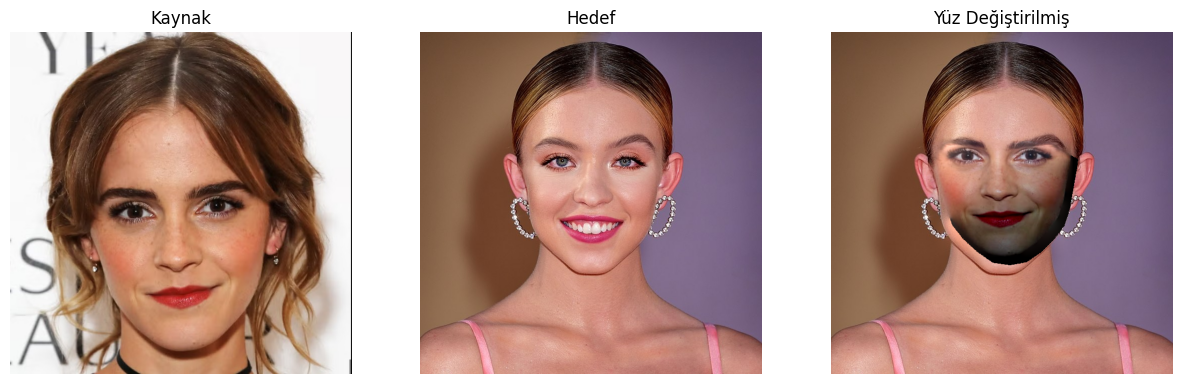

In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

# Landmark çıkarma ve region belirleme
def get_landmarks_and_regions(img, predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        raise Exception("Yüz bulunamadı.")

    shape = predictor(gray, faces[0])
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return landmarks

# Ana işlemleri yap
def face_swap_from_drive(source_path, target_path, predictor_path):
    # Görselleri yükle
    src = cv2.imread(source_path)
    tgt = cv2.imread(target_path)

    # RGB formatına çevir
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    tgt = cv2.cvtColor(tgt, cv2.COLOR_BGR2RGB)

    # Landmark çıkar
    src_points = get_landmarks_and_regions(src, predictor_path)
    tgt_points = get_landmarks_and_regions(tgt, predictor_path)

    # Maske oluştur (kaynak yüz)
    src_mask = np.zeros(src.shape[:2], dtype=np.uint8)
    src_hull = cv2.convexHull(src_points)
    cv2.fillConvexPoly(src_mask, src_hull, 255)

    # Affine hizalama için 3 nokta: sağ göz, sol göz, burun
    src_tri = np.float32([src_points[36], src_points[45], src_points[30]])
    tgt_tri = np.float32([tgt_points[36], tgt_points[45], tgt_points[30]])

    # Affine dönüşüm matrisi
    warp_mat = cv2.getAffineTransform(src_tri, tgt_tri)

    # Kaynağı ve maskeyi hedefe göre hizala
    warped_src_face = cv2.warpAffine(src, warp_mat, (tgt.shape[1], tgt.shape[0]))
    warped_src_mask = cv2.warpAffine(src_mask, warp_mat, (tgt.shape[1], tgt.shape[0]))

    # Hedefteki yüzü temizle (maske ile)
    tgt_clean = tgt.copy()
    tgt_clean[warped_src_mask == 255] = 0

    # Seamless clone (doğal yerleştirme)
    center = tuple(np.mean(tgt_points, axis=0).astype(int))
    output = cv2.seamlessClone(warped_src_face, tgt_clean, warped_src_mask, center, cv2.NORMAL_CLONE)

    return src, tgt, output

# Örnek kullanım
source_img_path = "/content/drive/MyDrive/emma_watson.jpg"
target_img_path = "/content/drive/MyDrive/sydney_sweeny.jpg"
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

src_img, tgt_img, swapped_img = face_swap_from_drive(source_img_path, target_img_path, predictor_path)

# Görüntüleri göster
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Kaynak")
plt.imshow(src_img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Hedef")
plt.imshow(tgt_img)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Yüz Değiştirilmiş")
plt.imshow(swapped_img)
plt.axis("off")
plt.show()
#kaynak yüzdeki değiştirilecek yerler silindi ve affine komutu 3 noktaya göre hizalama yapıyor

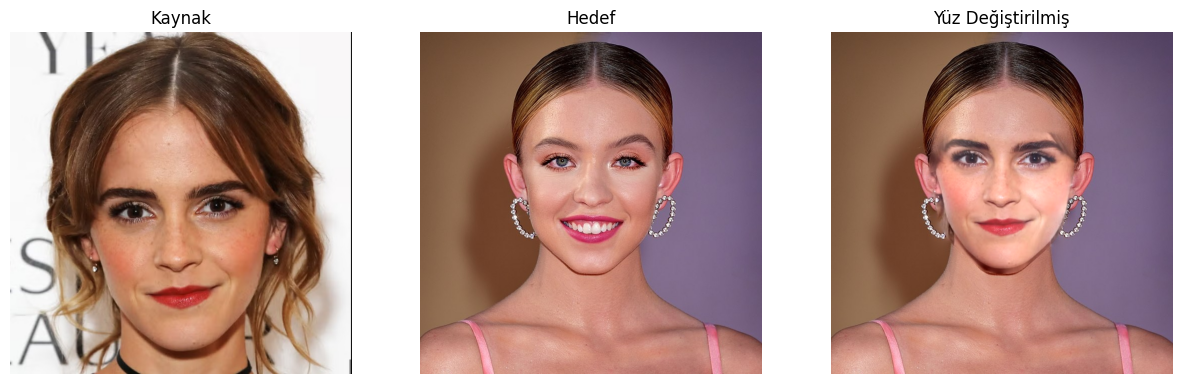

In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

# Landmark tespiti fonksiyonu
def get_landmarks(img, predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        raise ValueError("Yüz bulunamadı.")
    shape = predictor(gray, rects[0])
    coords = np.asarray([(pt.x, pt.y) for pt in shape.parts()])
    return coords

# Ana face swap fonksiyonu
def advanced_face_swap_fixed(src_path, tgt_path, predictor_path):
    src = cv2.imread(src_path)
    tgt = cv2.imread(tgt_path)

    if src is None or tgt is None:
        raise ValueError("Görüntüler yüklenemedi. Dosya yollarını kontrol edin.")

    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    tgt = cv2.cvtColor(tgt, cv2.COLOR_BGR2RGB)

    # Landmark'ları al
    src_landmarks = get_landmarks(src, predictor_path)
    tgt_landmarks = get_landmarks(tgt, predictor_path)

    # Affine hizalama
    M, _ = cv2.estimateAffinePartial2D(np.float32(src_landmarks), np.float32(tgt_landmarks))
    warped_src = cv2.warpAffine(src, M, (tgt.shape[1], tgt.shape[0]), borderMode=cv2.BORDER_REFLECT)

    # Maske: hedef yüzün convex hull'undan
    hull = cv2.convexHull(np.array(tgt_landmarks))
    mask = np.zeros(tgt.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, hull, 255)

    # Maskeyi genişlet (daha düzgün seamless clone için)
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Seamless clone uygulama
    center = (tgt.shape[1] // 2, tgt.shape[0] // 2)
    blended = cv2.seamlessClone(warped_src, tgt, mask, center, cv2.NORMAL_CLONE)

    return src, tgt, blended

# === Test kısmı ===
src_img_path = "/content/drive/MyDrive/emma_watson.jpg"
tgt_img_path = "/content/drive/MyDrive/sydney_sweeny.jpg"
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

src_img, tgt_img, swapped_img = advanced_face_swap_fixed(src_img_path, tgt_img_path, predictor_path)

# Görselleştir
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(src_img); plt.title("Kaynak"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(tgt_img); plt.title("Hedef"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(swapped_img); plt.title("Yüz Değiştirilmiş"); plt.axis('off')
plt.show()
#affine komutu güncellendi

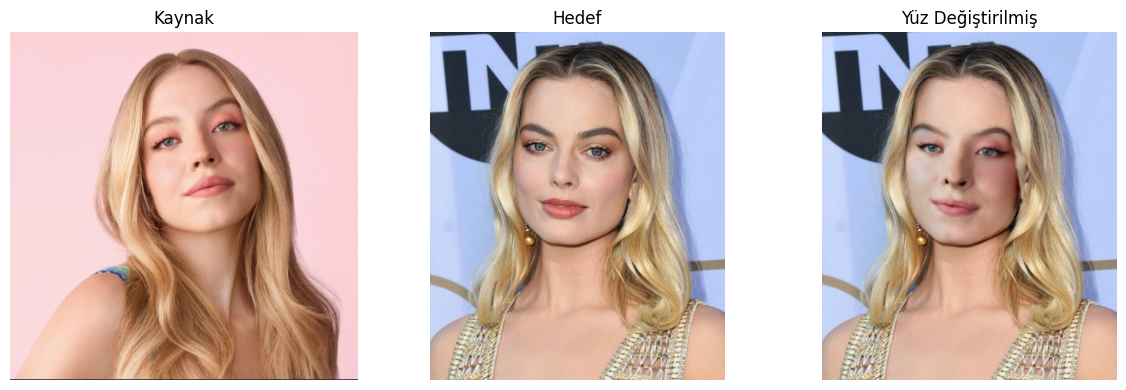

In [ ]:
# Gerekli kütüphaneler
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
# 68 nokta landmark çıkarma
def get_landmarks(img, detector, predictor):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    landmarks = predictor(gray, faces[0])
    return [(p.x, p.y) for p in landmarks.parts()]

# Yüz hizalama (affine transform ile)
def align_faces(src_img, src_points, tgt_points):
    src_points = np.array(src_points).astype(np.float32)
    tgt_points = np.array(tgt_points).astype(np.float32)
    M, _ = cv2.estimateAffinePartial2D(src_points, tgt_points)
    aligned_src = cv2.warpAffine(src_img, M, (src_img.shape[1], src_img.shape[0]), borderMode=cv2.BORDER_REFLECT)
    return aligned_src, M

# Delaunay üçgenleri hesaplama
def get_delaunay_tris(rect, points):
    subdiv = cv2.Subdiv2D(rect)
    for p in points:
        subdiv.insert((float(p[0]), float(p[1])))
    triangle_list = subdiv.getTriangleList()
    indices = []
    for t in triangle_list:
        pts = [(t[0], t[1]), (t[2], t[3]), (t[4], t[5])]
        idx = []
        for p in pts:
            for i, point in enumerate(points):
                if np.linalg.norm(np.array(p) - np.array(point)) < 1:
                    idx.append(i)
        if len(idx) == 3:
            indices.append(tuple(idx))
    return indices

# Her üçgeni warp et
def warp_triangle(src, dst, t_src, t_dst):
    src_rect = cv2.boundingRect(np.float32([t_src]))
    dst_rect = cv2.boundingRect(np.float32([t_dst]))

    src_crop = src[src_rect[1]:src_rect[1]+src_rect[3], src_rect[0]:src_rect[0]+src_rect[2]]
    dst_crop = dst[dst_rect[1]:dst_rect[1]+dst_rect[3], dst_rect[0]:dst_rect[0]+dst_rect[2]]

    t_src_offset = [(p[0] - src_rect[0], p[1] - src_rect[1]) for p in t_src]
    t_dst_offset = [(p[0] - dst_rect[0], p[1] - dst_rect[1]) for p in t_dst]

    M = cv2.getAffineTransform(np.float32(t_src_offset), np.float32(t_dst_offset))
    warped = cv2.warpAffine(src_crop, M, (dst_rect[2], dst_rect[3]), borderMode=cv2.BORDER_REFLECT)

    mask = np.zeros((dst_rect[3], dst_rect[2], 3), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(t_dst_offset), (1, 1, 1))

    dst_crop *= (1 - mask)
    dst_crop += warped * mask
    dst[dst_rect[1]:dst_rect[1]+dst_rect[3], dst_rect[0]:dst_rect[0]+dst_rect[2]] = dst_crop

# Ana fonksiyon
def face_swap_from_drive(src_path, tgt_path, predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    src = cv2.imread(src_path)
    tgt = cv2.imread(tgt_path)

    src_points = get_landmarks(src, detector, predictor)
    tgt_points = get_landmarks(tgt, detector, predictor)

    if src_points is None or tgt_points is None:
        raise Exception("Landmark bulunamadı!")

    # Yüz hizalama
    aligned_src, M = align_faces(src, src_points, tgt_points)
    aligned_src_points = [
        (int(p[0] * M[0, 0] + p[1] * M[0, 1] + M[0, 2]),
         int(p[0] * M[1, 0] + p[1] * M[1, 1] + M[1, 2])) for p in src_points
    ]

    rect = (0, 0, tgt.shape[1], tgt.shape[0])
    dt = get_delaunay_tris(rect, tgt_points)
    output = tgt.copy()
    for tri in dt:
        t_src = [aligned_src_points[i] for i in tri]
        t_tgt = [tgt_points[i] for i in tri]
        warp_triangle(aligned_src, output, t_src, t_tgt)

    # Maske oluştur ve seamless clone
    mask = np.zeros(tgt.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(np.array(tgt_points, dtype=np.int32)), 255)
    r = cv2.boundingRect(np.float32([tgt_points]))
    center = (r[0] + r[2]//2, r[1] + r[3]//2)

    seamless = cv2.seamlessClone(output, tgt, mask, center, cv2.NORMAL_CLONE)
    return src, tgt, seamless

# Örnek kullanım (Google Colab için yollar)
src_img_path = "/content/drive/MyDrive/test_pictures/sydney_sweeney2.jpg"
tgt_img_path = "/content/drive/MyDrive/test_pictures/margot_robbie.jpg"
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"

src_img, tgt_img, swapped_img = face_swap_from_drive(src_img_path, tgt_img_path, predictor_path)

# Görselleştir
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)); plt.title("Kaynak"); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(tgt_img, cv2.COLOR_BGR2RGB)); plt.title("Hedef"); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(swapped_img, cv2.COLOR_BGR2RGB)); plt.title("Yüz Değiştirilmiş"); plt.axis('off')
plt.tight_layout()
plt.show()
#yüz geometrisi ve farklı açılar için kare matrisler yerine delaunay üçgenleri kullanıldı.